# **Downloading the MedMNSIT dataset**

In [ ]:
!pip install medmnist

In [ ]:
!pip install scikit-learn

# **Question 1:**

## **Base Model**

### **Importing the dataset and normalizing it**

In [ ]:
pip install matplotlib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from medmnist import NoduleMNIST3D
import numpy as np

In [ ]:
train_dataset = NoduleMNIST3D(split='train', download=True)
val_dataset   = NoduleMNIST3D(split='val', download=True)
test_dataset  = NoduleMNIST3D(split='test', download=True)

100%|██████████| 29.3M/29.3M [00:25<00:00, 1.17MB/s]


In [ ]:
x_train, y_train = train_dataset.imgs, train_dataset.labels
x_val, y_val = val_dataset.imgs, val_dataset.labels
x_test, y_test = test_dataset.imgs, test_dataset.labels

In [ ]:
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

In [ ]:
x_train, x_val, x_test = x_train / 255.0, x_val / 255.0, x_test / 255.0

In [ ]:
print("NoduleMNSIT dataset shape:")
print(f"Train shape: {x_train.shape}")
print(f"Validation shape: {x_val.shape}")
print(f"Test shape: {x_test.shape}")

NoduleMNSIT dataset shape:
Train shape: (1158, 28, 28, 28, 1)
Validation shape: (165, 28, 28, 28, 1)
Test shape: (310, 28, 28, 28, 1)


### **Building the model**

In [ ]:
input_shape = x_train.shape[1:]

def build_model_nodule():
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv3D(32, (3,3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling3D((2,2,2)),

        layers.Conv3D(64, (3,3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling3D((2,2,2)),

        layers.Conv3D(128, (3,3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling3D((2,2,2)),


        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )

    return model


In [ ]:
model = build_model_nodule()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=10, mode='max', restore_best_weights=True)

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop]
)


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 14s 183ms/step - accuracy: 0.6439 - auc: 0.5319 - loss: 2.0185 - val_accuracy: 0.7455 - val_auc: 0.7540 - val_loss: 0.5270
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7429 - auc: 0.7785 - loss: 0.4792 - val_accuracy: 0.7455 - val_auc: 0.8049 - val_loss: 0.4932
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7986 - auc: 0.7959 - loss: 0.4528 - val_accuracy: 0.7455 - val_auc: 0.8632 - val_loss: 0.4982
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8005 - auc: 0.8381 - loss: 0.4421 - val_accuracy: 0.7455 - val_auc: 0.8276 - val_loss: 0.6341
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8320 - auc: 0.8775 - loss: 0.3933 - val_accuracy: 0.7455 - val_auc: 0.8429 - val_loss: 0.5933
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8156 - auc: 0.8298 - loss: 0.4279 - val_accuracy: 0.7455 - val_auc: 0.8539 - val_loss: 0.6692
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━

### **Learning curve**

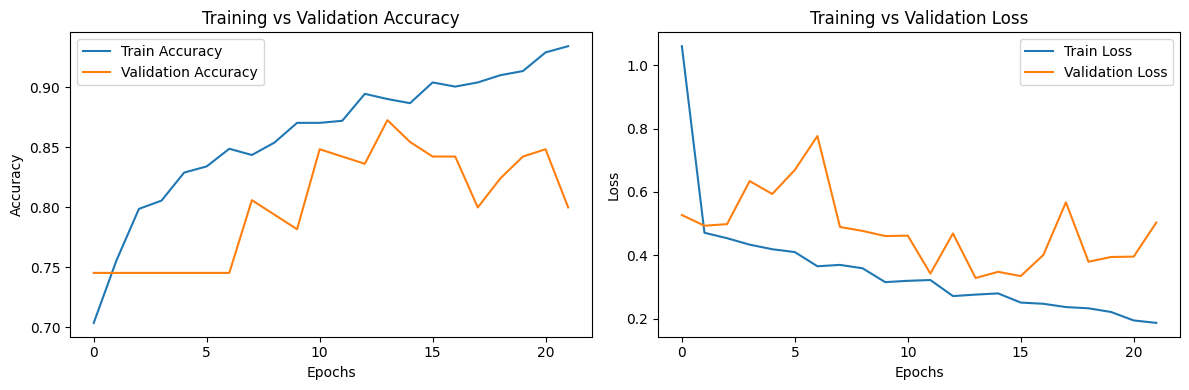

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - accuracy: 0.8875 - auc: 0.8541 - loss: 0.3126
Test Accuracy: 0.871, Test AUC (from evaluate): 0.900
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Test Accuracy: 0.871, Test AUC: 0.901


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()


axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

test_loss, test_acc, test_auc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.3f}, Test AUC (from evaluate): {test_auc:.3f}")

y_pred = model.predict(x_test).flatten()
auc = roc_auc_score(y_test, y_pred)

## **Fine tuning the base model to outperform the benchmark**

**Building the base model 5 convolution layers and 1 output layer and printing the learning curves**

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 20s 266ms/step - accuracy: 0.7194 - auc: 0.6177 - loss: 0.6626 - val_accuracy: 0.7576 - val_auc: 0.7910 - val_loss: 0.6390 - learning_rate: 0.0010
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7837 - auc: 0.7197 - loss: 0.5667 - val_accuracy: 0.7455 - val_auc: 0.8129 - val_loss: 0.5572 - learning_rate: 0.0010
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8345 - auc: 0.8243 - loss: 0.4665 - val_accuracy: 0.7455 - val_auc: 0.8629 - val_loss: 0.5863 - learning_rate: 0.0010
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8328 - auc: 0.8144 - loss: 0.4747 - val_accuracy: 0.7455 - val_auc: 0.7919 - val_loss: 0.6129 - learning_rate: 0.0010
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8135 - auc: 0.7944 - loss: 0.5057 - val_accuracy: 0.7455 - val_auc: 0.8452 - val_loss: 0.6432 - learning_rate: 0.0010
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8412 - auc: 

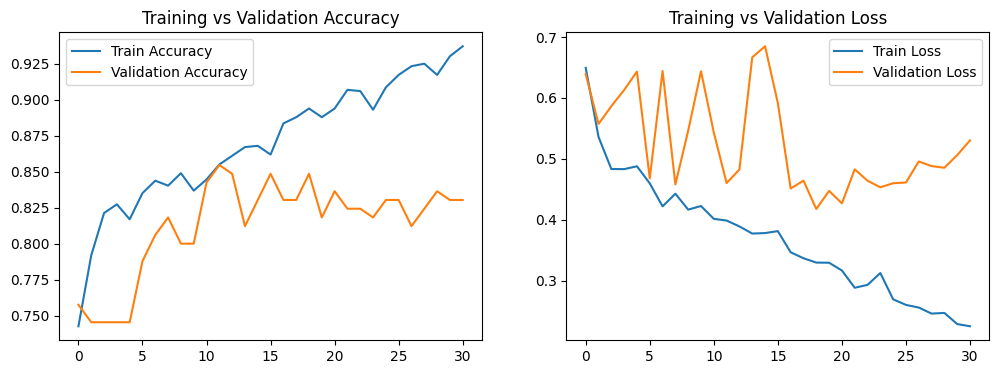

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - accuracy: 0.8935 - auc: 0.8760 - loss: 0.3817

Test Accuracy: 0.881, Test AUC: 0.908
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
ROC AUC (manual): 0.907


In [ ]:
input_shape = x_train.shape[1:]

def build_improved_model():
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv3D(32, (3,3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling3D((2,2,2)),

        layers.Conv3D(64, (3,3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling3D((2,2,2)),

        layers.Conv3D(128, (3,3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling3D((2,2,2)),

        layers.Conv3D(256, (3,3,3), padding='same', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling3D((2,2,2)),

        layers.Conv3D(512, (3,3,3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.GlobalAveragePooling3D(),


        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', AUC(name='auc')]
    )
    return model

model = build_improved_model()

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc', factor=0.5, patience=5, verbose=1, mode='max', min_lr=1e-6
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=12, mode='max', restore_best_weights=True
)

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].legend()
plt.show()

test_loss, test_acc, test_auc = model.evaluate(x_test, y_test)
print(f"\nTest Accuracy: {test_acc:.3f}, Test AUC: {test_auc:.3f}")

y_pred = model.predict(x_test).flatten()
auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC (manual): {auc:.3f}")




**Save and load the model**

In [ ]:
model.save("base_model_nodule3d.keras")

In [ ]:
model = tf.keras.models.load_model("base_model_nodule3d.keras")

**Freeze the layers**

Epoch 1/20
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8483 - auc: 0.8658 - loss: 0.4771
Epoch 1: val_auc improved from -inf to 0.89199, saving model to fine_tuned_nodule3d.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - accuracy: 0.8482 - auc: 0.8659 - loss: 0.4768 - val_accuracy: 0.8545 - val_auc: 0.8920 - val_loss: 0.4666 - learning_rate: 5.0000e-06
Epoch 2/20
68/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8516 - auc: 0.8678 - loss: 0.4566
Epoch 2: val_auc improved from 0.89199 to 0.89353, saving model to fine_tuned_nodule3d.keras
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8513 - auc: 0.8678 - loss: 0.4570 - val_accuracy: 0.8485 - val_auc: 0.8935 - val_loss: 0.4744 - learning_rate: 5.0000e-06
Epoch 3/20
69/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8620 - auc: 0.8824 - loss: 0.4341
Epoch 3: val_auc did not improve from 0.89353
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8618 - auc: 0.8821 - loss: 0.4349 - val_accuracy: 0.8485 - val_auc: 0.8

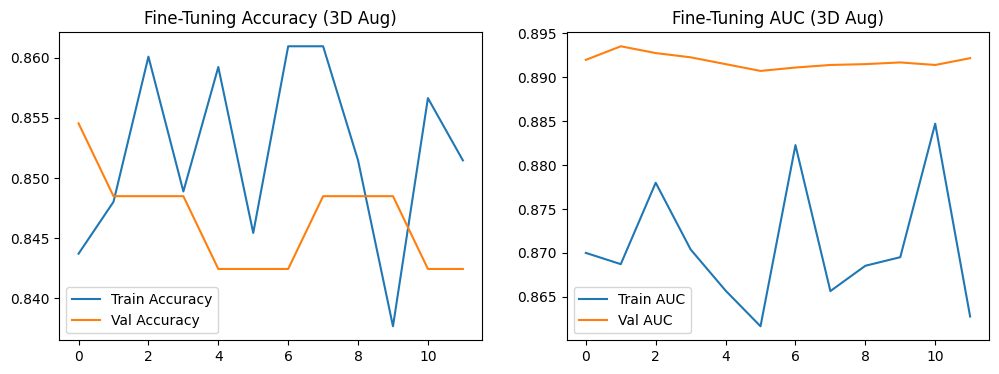

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step - accuracy: 0.8919 - auc: 0.8812 - loss: 0.4312

 After Fine-Tuning → Test Accuracy: 0.910, Test AUC: 0.881


In [ ]:

from tensorflow import keras

for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-10:]:
    if isinstance(layer, keras.layers.Conv3D) or isinstance(layer, keras.layers.BatchNormalization):
        layer.trainable = True

loss = keras.losses.BinaryCrossentropy(label_smoothing=0.05)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-6),
    loss=loss,
    metrics=[keras.metrics.AUC(name='auc'), 'accuracy']
)


lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc', factor=0.5, patience=4, verbose=1, mode='max', min_lr=1e-6
)
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_auc', patience=10, mode='max', restore_best_weights=True
)
checkpoint = keras.callbacks.ModelCheckpoint(
    "fine_tuned_nodule3d.keras", monitor="val_auc", mode="max", save_best_only=True, verbose=1
)


def augment_3d(x, y):
    x = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.reverse(x, axis=[1]), lambda: x)  # vertical
    x = tf.cond(tf.random.uniform(()) > 0.5, lambda: tf.reverse(x, axis=[2]), lambda: x)  # horizontal

    noise = tf.random.uniform(shape=tf.shape(x), minval=-0.05, maxval=0.05, dtype=x.dtype)
    x = tf.clip_by_value(x + noise, 0.0, 1.0)

    return x, y

batch_size = 16
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    tf.data.Dataset.from_tensor_slices((x_train, y_train))
    .shuffle(512)
    .map(augment_3d, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

val_dataset = (
    tf.data.Dataset.from_tensor_slices((x_val, y_val))
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)


fine_tune_history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stop, lr_scheduler, checkpoint],
    verbose=1
)


fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(fine_tune_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(fine_tune_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Fine-Tuning Accuracy (3D Aug)')
axes[0].legend()

axes[1].plot(fine_tune_history.history['auc'], label='Train AUC')
axes[1].plot(fine_tune_history.history['val_auc'], label='Val AUC')
axes[1].set_title('Fine-Tuning AUC (3D Aug)')
axes[1].legend()
plt.show()


test_loss, test_acc, test_auc = model.evaluate(x_test, y_test)
print(f"\n After Fine-Tuning → Test Accuracy: {test_acc:.3f}, Test AUC: {test_auc:.3f}")


In [ ]:
import numpy as np
from sklearn.metrics import roc_auc_score

def tta_predict_3d(model, x, flips=('none', 'h', 'v', 'hv')):
    def apply_flip(vol, mode):
        if mode == 'none':
            return vol
        if mode == 'h':
            return vol[:, :, ::-1, :]
        if mode == 'v':
            return vol[:, ::-1, :, :]
        if mode == 'hv':
            return vol[:, ::-1, ::-1, :]
        return vol

    preds = []
    for f in flips:
        x_f = np.array([apply_flip(v, f) for v in x])
        p = model.predict(x_f, verbose=0).reshape(-1)
        preds.append(p)
    return np.mean(np.stack(preds, axis=0), axis=0)

y_test_pred_tta = tta_predict_3d(model, x_test)
test_auc_tta = roc_auc_score(y_test, y_test_pred_tta)

print(f"\n Final Test AUC (with TTA): {test_auc_tta:.3f}")



 Final Test AUC (with TTA): 0.915


# **Question 2:**

## **2a**

In [ ]:
!pip install tensorflow-model-optimization

In [ ]:
from tensorflow.keras.optimizers import Adam
from medmnist import ChestMNIST
from tensorflow.keras.metrics import AUC
import numpy as np

In [ ]:
train_dataset_chest = ChestMNIST(split='train', download=True)
val_dataset_chest   = ChestMNIST(split='val', download=True)
test_dataset_chest  = ChestMNIST(split='test', download=True)

x_train_chest, y_train_chest = train_dataset_chest.imgs, train_dataset_chest.labels
x_val_chest,   y_val_chest   = val_dataset_chest.imgs,  val_dataset_chest.labels
x_test_chest,  y_test_chest  = test_dataset_chest.imgs, test_dataset_chest.labels

x_train_chest = x_train_chest[..., np.newaxis]/255.0
x_val_chest   = x_val_chest[..., np.newaxis]/255.0
x_test_chest  = x_test_chest[..., np.newaxis]/255.0


100%|██████████| 82.8M/82.8M [00:04<00:00, 17.2MB/s]


In [ ]:
print("ChestMNIST dataset shape:")
print(f"Training set: {x_train_chest.shape}, labels: {y_train_chest.shape}")
print(f"Validation set: {x_val_chest.shape}, labels: {y_val_chest.shape}")
print(f"Test set: {x_test_chest.shape}, labels: {y_test_chest.shape}")
print(f"Unique labels in training set: {np.unique(np.sum(y_train_chest, axis=1))}")

ChestMNIST dataset shape:
Training set: (78468, 28, 28, 1), labels: (78468, 14)
Validation set: (11219, 28, 28, 1), labels: (11219, 14)
Test set: (22433, 28, 28, 1), labels: (22433, 14)
Unique labels in training set: [0 1 2 3 4 5 6 7 8 9]


**Without augmentation**

In [ ]:
input_shape = x_train_chest.shape[1:]

def build_model_chest():
    model = models.Sequential([
        # Block 1
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.2),

        # Block 2
        layers.Conv2D(64, (3,3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        # Block 3
        layers.Conv2D(128, (3,3), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.4),

        # Fully connected
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(14, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.AUC(name='auc')]
    )

    return model


In [ ]:
model = build_model_chest()

print("Model summary:")
model.summary()


Model summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 392,110 (1.50 MB)

 Trainable params: 391,662 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=15, restore_best_weights=True)

history = model.fit(x_train_chest, y_train_chest,
                    validation_data=(x_val_chest, y_val_chest),
                    epochs=100,
                    batch_size=64,
                    callbacks=[early_stop])


Epoch 1/100


2025-10-10 03:04:22.007005: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_11/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1227/1227 [==============================] - 12s 8ms/step - loss: 0.2205 - binary_accuracy: 0.9399 - auc: 0.6705 - val_loss: 0.1881 - val_binary_accuracy: 0.9492 - val_auc: 0.7779
Epoch 2/100
1227/1227 [==============================] - 9s 8ms/step - loss: 0.1899 - binary_accuracy: 0.9484 - auc: 0.7286 - val_loss: 0.1870 - val_binary_accuracy: 0.9492 - val_auc: 0.7861
Epoch 3/100
1227/1227 [==============================] - 9s 8ms/step - loss: 0.1844 - binary_accuracy: 0.9485 - auc: 0.7460 - val_loss: 0.1796 - val_binary_accuracy: 0.9492 - val_auc: 0.7881
Epoch 4/100
1227/1227 [==============================] - 9s 7ms/step - loss: 0.1819 - binary_accuracy: 0.9486 - auc: 0.7547 - val_loss: 0.1790 - val_binary_accuracy: 0.9492 - val_auc: 0.7934
Epoch 5/100
1227/1227 [==============================] - 10s 8ms/step - loss: 0.1801 - binary_accuracy: 0.9486 - auc: 0.7617 - val_loss: 0.1726 - val_binary_accuracy: 0.9492 - val_auc: 0.7977
Epoch 6/100
1227/1227 [==============================] 

In [ ]:
# Save it flat — no extra Sequential wrapper
model.save('chestmnist_base_model_flat.keras')

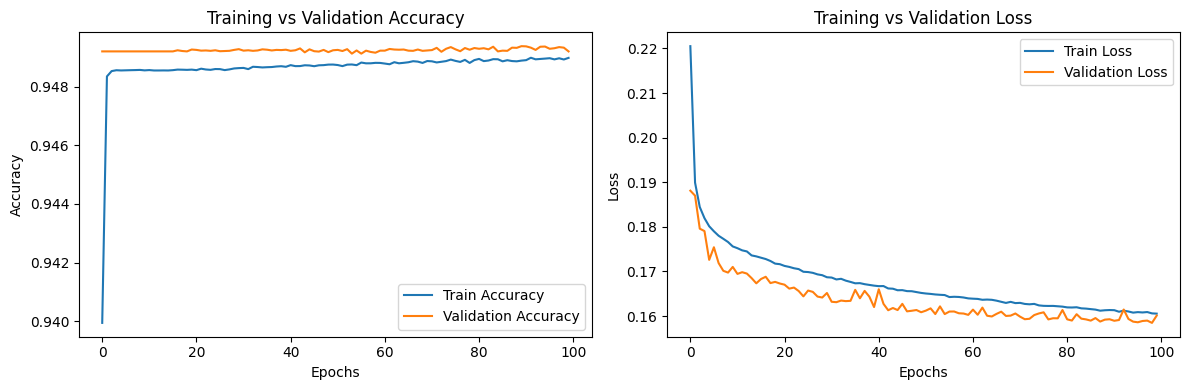

Evaluation on test data
702/702 [==============================] - 3s 4ms/step - loss: 0.1653 - binary_accuracy: 0.9478 - auc: 0.8312
Test Loss: 0.165, Test Accuracy: 0.948, Test AUC: 0.831
702/702 [==============================] - 1s 1ms/step


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['binary_accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()


axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

print("Evaluation on test data")
test_loss_chest, test_acc_chest, test_auc_chest = model.evaluate(x_test_chest, y_test_chest)
print(f"Test Loss: {test_loss_chest:.3f}, Test Accuracy: {test_acc_chest:.3f}, Test AUC: {test_auc_chest:.3f}")

y_pred_chest = model.predict(x_test_chest)

**With augmentation**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rotation_range=25,      # rotation
    zoom_range=0.15,        # zoom
    horizontal_flip=True,   # flipping
    width_shift_range=0.05,  # shift
    height_shift_range=0.05,
    fill_mode='nearest'
)

In [ ]:
print(x_train_chest.shape)

(78468, 28, 28, 1)


In [ ]:
data_gen.fit(x_train_chest)

aug_model = build_model_chest()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_auc', mode='max', patience=10, restore_best_weights=True)


aug_history = aug_model.fit(
    data_gen.flow(x_train_chest, y_train_chest, batch_size=64),
    validation_data=(x_val_chest, y_val_chest),
    epochs=100,
    callbacks=[early_stop]
)

Epoch 1/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 37s 24ms/step - auc: 0.6415 - binary_accuracy: 0.9248 - loss: 0.2560 - val_auc: 0.7788 - val_binary_accuracy: 0.9492 - val_loss: 0.1938
Epoch 2/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - auc: 0.7225 - binary_accuracy: 0.9482 - loss: 0.1921 - val_auc: 0.7837 - val_binary_accuracy: 0.9492 - val_loss: 0.1866
Epoch 3/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - auc: 0.7424 - binary_accuracy: 0.9488 - loss: 0.1845 - val_auc: 0.7873 - val_binary_accuracy: 0.9492 - val_loss: 0.1828
Epoch 4/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - auc: 0.7504 - binary_accuracy: 0.9490 - loss: 0.1816 - val_auc: 0.7893 - val_binary_accuracy: 0.9492 - val_loss: 0.1769
Epoch 5/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - auc: 0.7572 - binary_accuracy: 0.9488 - loss: 0.1804 - val_auc: 0.7902 - val_binary_accuracy: 0.9492 - val_loss: 0.1770
Epoch 6/100
1227/1227 ━━━━━━━━━━━━━━━━━━━━ 23s 19ms/step - auc: 0.7588 - binary_accuracy: 0.9485 - loss: 

In [ ]:
aug_model.save('chestmnist_aug_model.h5')

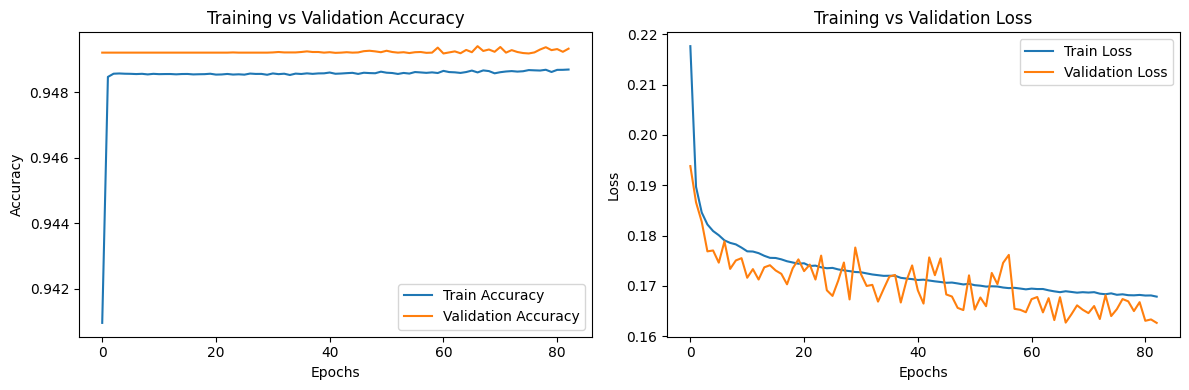

702/702 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc: 0.8278 - binary_accuracy: 0.9477 - loss: 0.1677
Augmented CNN → Accuracy: 0.948, Test AUC: 0.826
702/702 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(aug_history.history['binary_accuracy'], label='Train Accuracy')
axes[0].plot(aug_history.history['val_binary_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()


axes[1].plot(aug_history.history['loss'], label='Train Loss')
axes[1].plot(aug_history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


test_loss_aug, test_acc_aug, test_auc_aug = aug_model.evaluate(x_test_chest, y_test_chest)
print(f"Augmented CNN → Accuracy: {test_acc_aug:.3f}, Test AUC: {test_auc_aug:.3f}")

y_pred_chest = model.predict(x_test_chest)


## **2b**

In [ ]:
!pip install scikit-multilearn medmnist


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, accuracy_score
from skmultilearn.model_selection import iterative_train_test_split
from medmnist import ChestMNIST
import matplotlib.pyplot as plt


import os
import json


In [ ]:
print(os.getcwd())

/app


**Sampling the dataset to 30% as it was taking very long time to run**

In [ ]:
def sample_fraction(X, Y, frac, seed=42):
    np.random.seed(seed)
    n_samples = int(len(X) * frac)
    idx = np.random.choice(len(X), n_samples, replace=False)
    return X[idx], Y[idx]


train_full = ChestMNIST(split="train", download=True)
val_full   = ChestMNIST(split="val", download=True)
test_full  = ChestMNIST(split="test", download=True)

x_train, y_train = train_full.imgs, train_full.labels
x_val,   y_val   = val_full.imgs,   val_full.labels
x_test,  y_test  = test_full.imgs,  test_full.labels


FRACTION = 0.3

x_train_s, y_train_s = sample_fraction(x_train, y_train, FRACTION)
x_val_s,   y_val_s   = sample_fraction(x_val,   y_val,   FRACTION)

In [ ]:
print("x_train_s:", x_train_s.shape, "y_train_s:", y_train_s.shape)
print("x_val_s:", x_val_s.shape, "y_val_s:", y_val_s.shape)

x_train_s: (23540, 28, 28) y_train_s: (23540, 14)
x_val_s: (3365, 28, 28) y_val_s: (3365, 14)


In [ ]:
NUM_CLASSES = y_train_s.shape[1]
BATCH_SIZE = 64

**Preprocessing the dataset and printing the shape**

In [ ]:
import numpy as np

x_train_s = np.asarray(x_train_s, dtype='float32')
x_val_s   = np.asarray(x_val_s, dtype='float32')
x_test    = np.asarray(x_test, dtype='float32')


if x_train_s.ndim == 3 and x_train_s.shape[-1] == 84:
    x_train_s = x_train_s.reshape(-1, 28, 28)
    x_val_s   = x_val_s.reshape(-1, 28, 28)
    x_test    = x_test.reshape(-1, 28, 28)

if x_train_s.ndim == 3:
    x_train_s = np.expand_dims(x_train_s, -1)
    x_val_s   = np.expand_dims(x_val_s, -1)
    x_test    = np.expand_dims(x_test, -1)

x_train_s = np.repeat(x_train_s, 3, axis=-1)
x_val_s   = np.repeat(x_val_s, 3, axis=-1)
x_test    = np.repeat(x_test, 3, axis=-1)

print("✅ Shapes after fix:")
print(x_train_s.shape, x_val_s.shape, x_test.shape)


✅ Shapes after fix:
(23540, 28, 28, 3) (3365, 28, 28, 3) (22433, 28, 28, 3)


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

def resize_generator(gen, target_size=(224, 224)):
    for x_batch, y_batch in gen:
        x_resized = tf.image.resize(x_batch, target_size)
        yield x_resized, y_batch


train_gen= train_datagen.flow(
    x_train_s,
    y_train_s,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow(
    x_val_s,
    y_val_s,
    batch_size=BATCH_SIZE,
    shuffle=False
)


train_gen = resize_generator(train_gen, target_size=(224, 224))
val_gen   = resize_generator(val_gen,   target_size=(224, 224))

In [ ]:
import math

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen_base = test_datagen.flow(
    x_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

def resize_generator(gen, target_size=(224,224)):
    for xb, yb in gen:
        yield tf.image.resize(xb, target_size), yb

test_gen = resize_generator(test_gen_base, target_size=(224,224))
test_steps = math.ceil(len(x_test) / BATCH_SIZE)

**Defining the common metrics for both the models**


In [ ]:
from tensorflow.keras.applications import VGG16

steps_per_epoch = len(x_train_s) // BATCH_SIZE
val_steps = len(x_val_s) // BATCH_SIZE

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', mode='min', patience=10, restore_best_weights=True
)

common_metrics = [
    tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
    tf.keras.metrics.AUC(name='auc', multi_label=True)
]


**Building the model --> Freeze All**

In [ ]:
def build_vgg16_model(freeze_all=True, freeze_layers=8):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    if freeze_all:
        for layer in base_model.layers:
            layer.trainable = False
    else:
        for layer in base_model.layers[:freeze_layers]:
            layer.trainable = False
        for layer in base_model.layers[freeze_layers:]:
            layer.trainable = True

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(1e-4),
        loss='binary_crossentropy',
        metrics=common_metrics
    )
    return model


In [ ]:
print("Training: FREEZE_ALL")

model_freeze_all = build_vgg16_model(freeze_all=True)

history_all = model_freeze_all.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=[early_stop],
    verbose=1
)


Training: FREEZE_ALL
Epoch 1/100
367/367 [==============================] - 25s 66ms/step - loss: 0.2441 - binary_accuracy: 0.9279 - auc: 0.5005 - val_loss: 0.1805 - val_binary_accuracy: 0.9498 - val_auc: 0.5165
Epoch 2/100
367/367 [==============================] - 24s 66ms/step - loss: 0.2026 - binary_accuracy: 0.9470 - auc: 0.4984 - val_loss: 0.1789 - val_binary_accuracy: 0.9501 - val_auc: 0.5321
Epoch 3/100
367/367 [==============================] - 23s 64ms/step - loss: 0.1951 - binary_accuracy: 0.9485 - auc: 0.5026 - val_loss: 0.1795 - val_binary_accuracy: 0.9498 - val_auc: 0.5464
Epoch 4/100
367/367 [==============================] - 24s 64ms/step - loss: 0.1916 - binary_accuracy: 0.9490 - auc: 0.5042 - val_loss: 0.1785 - val_binary_accuracy: 0.9501 - val_auc: 0.5416
Epoch 5/100
367/367 [==============================] - 23s 63ms/step - loss: 0.1914 - binary_accuracy: 0.9482 - auc: 0.5123 - val_loss: 0.1791 - val_binary_accuracy: 0.9498 - val_auc: 0.5547
Epoch 6/100
367/367 [===

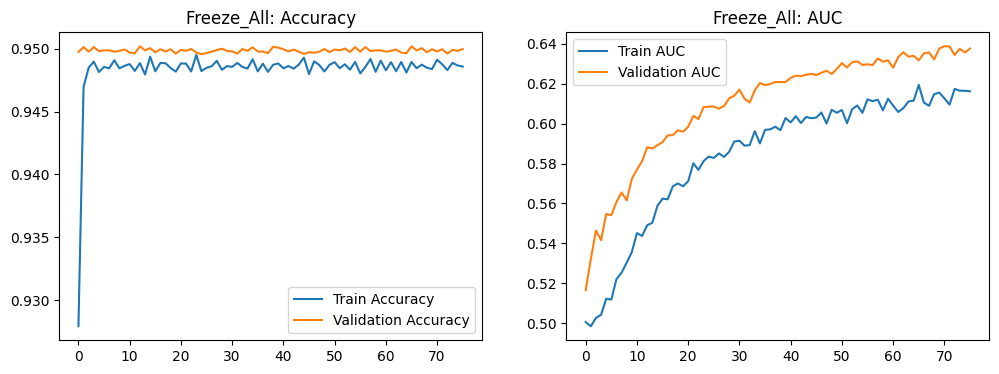

Evaluating on test data...
351/351 [==============================] - 19s 55ms/step
Freeze_All → Test AUC: 0.649, Test Accuracy: 0.947


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_all.history['binary_accuracy'], label='Train Accuracy')
axes[0].plot(history_all.history['val_binary_accuracy'], label='Validation Accuracy')
axes[0].set_title('Freeze_All: Accuracy')
axes[0].legend()

axes[1].plot(history_all.history['auc'], label='Train AUC')
axes[1].plot(history_all.history['val_auc'], label='Validation AUC')
axes[1].set_title('Freeze_All: AUC')
axes[1].legend()
plt.show()

print("Evaluating on test data...")
preds_all = model_freeze_all.predict(test_gen, steps=test_steps, verbose=1)
preds_all = preds_all[:len(y_test)]

auc_all = roc_auc_score(y_test, preds_all, average='macro')
acc_all = tf.keras.metrics.BinaryAccuracy()(y_test, preds_all).numpy()

print(f"Freeze_All → Test AUC: {auc_all:.3f}, Test Accuracy: {acc_all:.3f}")

model_freeze_all.save("Freeze_All_vgg16_chestnet.keras")

**Building the model --> Freeze half**

In [ ]:
import math

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen_base = test_datagen.flow(
    x_test, y_test,
    batch_size=BATCH_SIZE,
    shuffle=False
)

def resize_generator(gen, target_size=(224,224)):
    for xb, yb in gen:
        yield tf.image.resize(xb, target_size), yb

test_gen = resize_generator(test_gen_base, target_size=(224,224))
test_steps = math.ceil(len(x_test) / BATCH_SIZE)

In [ ]:
print("Training: FREEZE_HALF")
model_freeze_half = build_vgg16_model(freeze_all=False, freeze_layers=8)

history_half = model_freeze_half.fit(
    train_gen,
    validation_data=val_gen,
    epochs=100,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    callbacks=[early_stop],
    verbose=1
)

Training: FREEZE_HALF
Epoch 1/100
367/367 [==============================] - 36s 92ms/step - loss: 0.2343 - binary_accuracy: 0.9321 - auc: 0.5133 - val_loss: 0.1779 - val_binary_accuracy: 0.9498 - val_auc: 0.5803
Epoch 2/100
367/367 [==============================] - 34s 92ms/step - loss: 0.1977 - binary_accuracy: 0.9478 - auc: 0.5324 - val_loss: 0.1776 - val_binary_accuracy: 0.9496 - val_auc: 0.5973
Epoch 3/100
367/367 [==============================] - 35s 94ms/step - loss: 0.1911 - binary_accuracy: 0.9484 - auc: 0.5514 - val_loss: 0.1744 - val_binary_accuracy: 0.9497 - val_auc: 0.6366
Epoch 4/100
367/367 [==============================] - 35s 95ms/step - loss: 0.1862 - binary_accuracy: 0.9483 - auc: 0.5754 - val_loss: 0.1715 - val_binary_accuracy: 0.9497 - val_auc: 0.6497
Epoch 5/100
367/367 [==============================] - 35s 95ms/step - loss: 0.1824 - binary_accuracy: 0.9487 - auc: 0.5993 - val_loss: 0.1696 - val_binary_accuracy: 0.9498 - val_auc: 0.6712
Epoch 6/100
367/367 [==

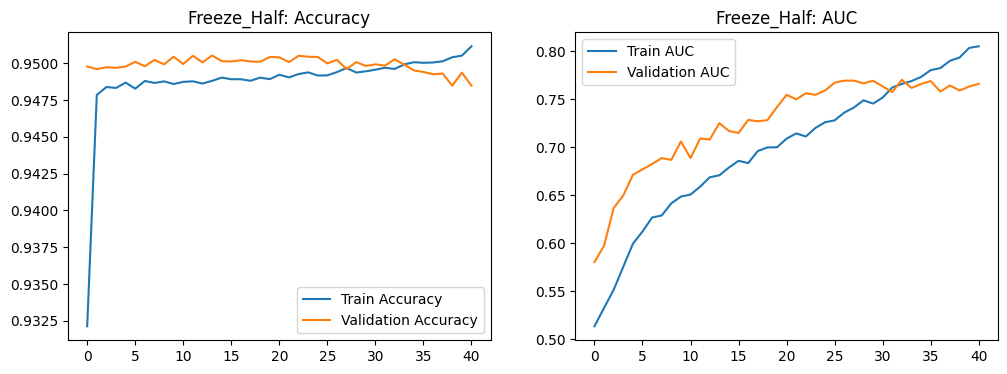

Evaluating on test data...
351/351 [==============================] - 19s 53ms/step
Freeze_Half → AUC: 0.744, BinaryAccuracy: 0.948


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history_half.history['binary_accuracy'], label='Train Accuracy')
axes[0].plot(history_half.history['val_binary_accuracy'], label='Validation Accuracy')
axes[0].set_title('Freeze_Half: Accuracy')
axes[0].legend()

axes[1].plot(history_half.history['auc'], label='Train AUC')
axes[1].plot(history_half.history['val_auc'], label='Validation AUC')
axes[1].set_title('Freeze_Half: AUC')
axes[1].legend()
plt.show()

print("Evaluating on test data...")
preds_half = model_freeze_half.predict(test_gen, steps=test_steps, verbose=1)
preds_half = preds_half[:len(y_test)]

auc_half = roc_auc_score(y_test, preds_half, average='macro')
acc_half = tf.keras.metrics.BinaryAccuracy()(y_test, preds_half).numpy()

print(f"Freeze_Half → AUC: {auc_half:.3f}, BinaryAccuracy: {acc_half:.3f}")

model_freeze_half.save("Freeze_Half_vgg16_chestnet.keras")

## **2c**

**Finding the last convolution layer**


In [ ]:
from tensorflow.keras import layers, Model

def find_last_conv_layer_name(m):
    for l in reversed(m.layers):
        if isinstance(l, layers.Conv2D):
            return l.name
    raise ValueError("No Conv2D layer found.")
LAST_CONV = find_last_conv_layer_name(model)
print("Using last conv layer:", LAST_CONV)


Using last conv layer: conv2d_2


**Building the GRADcam**

In [ ]:

def build_gradcam_submodel(baseline_model, last_conv_name):
    inp = tf.keras.Input(shape=baseline_model.input_shape[1:])
    y = inp
    conv_tensor = None
    for l in baseline_model.layers:
        y = l(y)
        if l.name == last_conv_name:
            conv_tensor = y
    return Model(inputs=inp, outputs=[conv_tensor, y], name="gradcam_submodel")

grad_model = build_gradcam_submodel(model, LAST_CONV)


**Building the heatmap**

In [ ]:
def gradcam_heatmap_with_submodel(grad_model, img1x, class_index):
    with tf.GradientTape() as tape:
        conv_out, preds = grad_model(img1x, training=False)
        score = preds[:, class_index]

    grads   = tape.gradient(score, conv_out)

    weights = tf.reduce_mean(grads, axis=(0,1,2))

    cam     = tf.reduce_sum(conv_out[0] * weights, axis=-1)
    cam     = tf.nn.relu(cam)
    cam     = cam / (tf.reduce_max(cam) + 1e-8)


    cam     = tf.image.resize(cam[..., None], (28, 28), method="bilinear")[..., 0]
    return cam.numpy().astype("float32")

**Overlay the heatmap on image and printing the heatmap and original image**


=== Class 0: 5 positive examples ===
idx 17342 | P(class 0) = 0.500
idx 9791 | P(class 0) = 0.505
idx 14382 | P(class 0) = 0.497
idx 1993 | P(class 0) = 0.495
idx 9639 | P(class 0) = 0.501


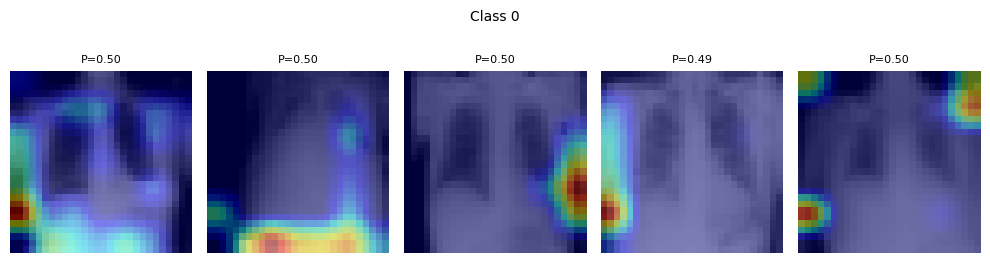


=== Class 1: 5 positive examples ===
idx 21689 | P(class 1) = 0.486
idx 2082 | P(class 1) = 0.489
idx 11814 | P(class 1) = 0.496
idx 17165 | P(class 1) = 0.496
idx 16662 | P(class 1) = 0.492


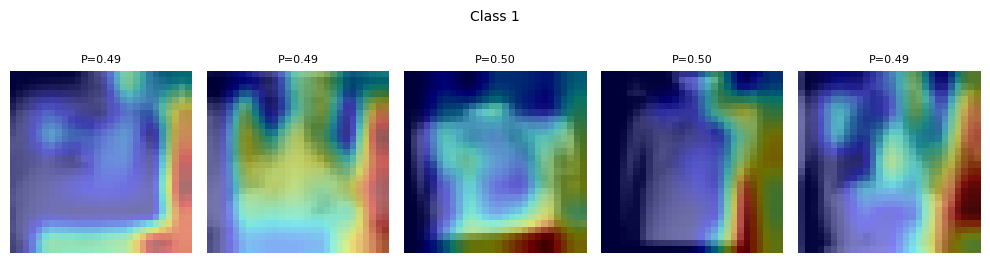


=== Class 2: 5 positive examples ===
idx 10821 | P(class 2) = 0.497
idx 18913 | P(class 2) = 0.496
idx 9740 | P(class 2) = 0.500
idx 8123 | P(class 2) = 0.498
idx 3968 | P(class 2) = 0.500


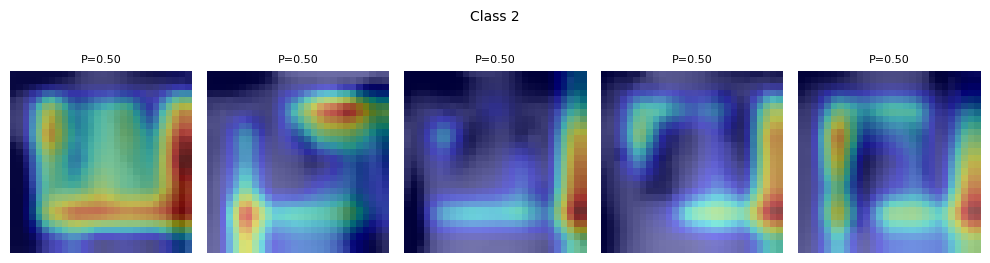


=== Class 3: 5 positive examples ===
idx 12118 | P(class 3) = 0.522
idx 5187 | P(class 3) = 0.519
idx 10153 | P(class 3) = 0.521
idx 9969 | P(class 3) = 0.519
idx 18477 | P(class 3) = 0.520


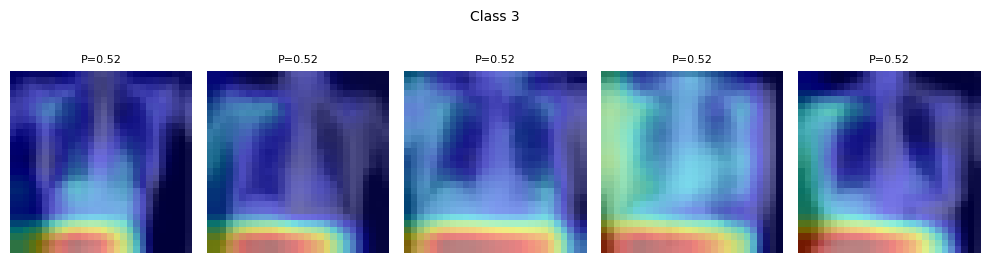


=== Class 4: 5 positive examples ===
idx 3538 | P(class 4) = 0.478
idx 18794 | P(class 4) = 0.478
idx 18121 | P(class 4) = 0.489
idx 5915 | P(class 4) = 0.481
idx 13628 | P(class 4) = 0.481


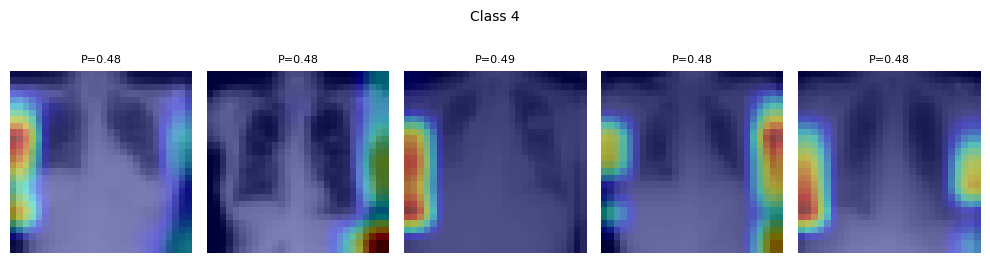


=== Class 5: 5 positive examples ===
idx 20180 | P(class 5) = 0.532
idx 17851 | P(class 5) = 0.535
idx 9942 | P(class 5) = 0.524
idx 21829 | P(class 5) = 0.527
idx 15602 | P(class 5) = 0.522


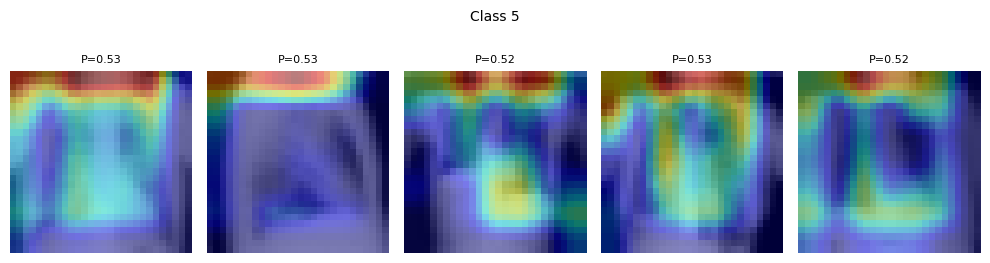


=== Class 6: 5 positive examples ===
idx 1005 | P(class 6) = 0.518
idx 10148 | P(class 6) = 0.515
idx 10933 | P(class 6) = 0.514
idx 15699 | P(class 6) = 0.511
idx 3433 | P(class 6) = 0.523


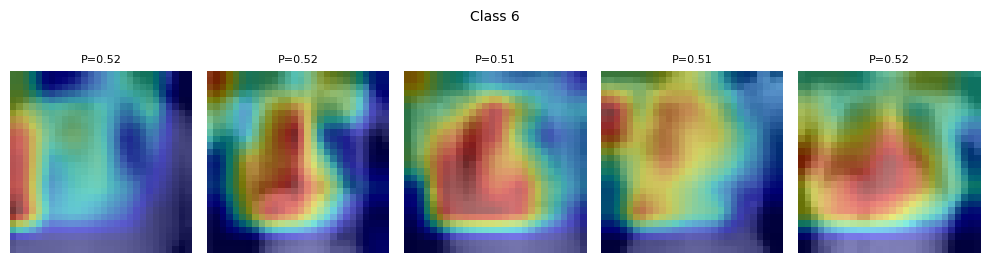


=== Class 7: 5 positive examples ===
idx 20212 | P(class 7) = 0.489
idx 8767 | P(class 7) = 0.484
idx 7685 | P(class 7) = 0.488
idx 9567 | P(class 7) = 0.485
idx 21613 | P(class 7) = 0.486


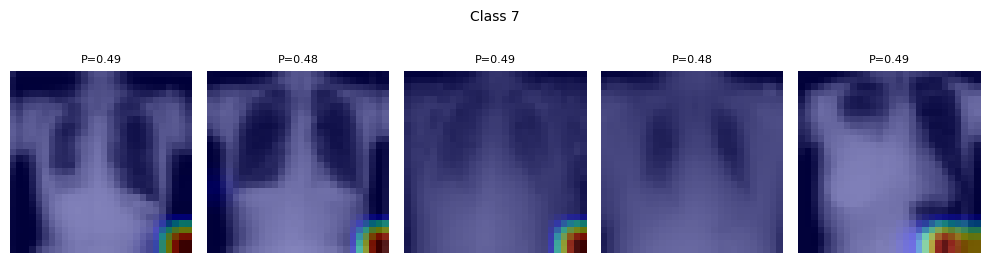


=== Class 8: 5 positive examples ===
idx 10394 | P(class 8) = 0.516
idx 7197 | P(class 8) = 0.515
idx 10641 | P(class 8) = 0.518
idx 15517 | P(class 8) = 0.513
idx 2998 | P(class 8) = 0.521


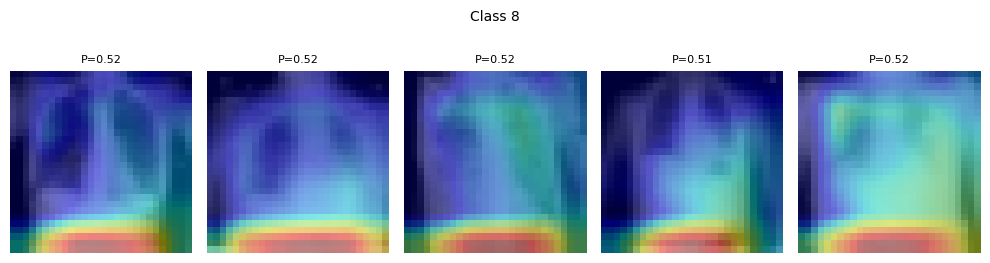


=== Class 9: 5 positive examples ===
idx 15699 | P(class 9) = 0.483
idx 13725 | P(class 9) = 0.490
idx 18804 | P(class 9) = 0.484
idx 2978 | P(class 9) = 0.489
idx 9241 | P(class 9) = 0.486


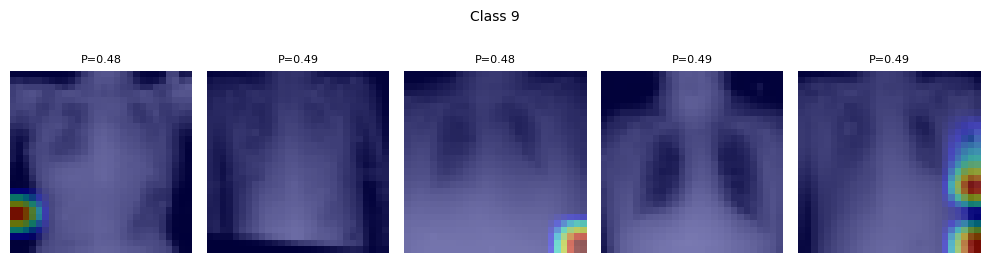


=== Class 10: 5 positive examples ===
idx 8947 | P(class 10) = 0.507
idx 19922 | P(class 10) = 0.508
idx 18867 | P(class 10) = 0.508
idx 10168 | P(class 10) = 0.507
idx 18243 | P(class 10) = 0.511


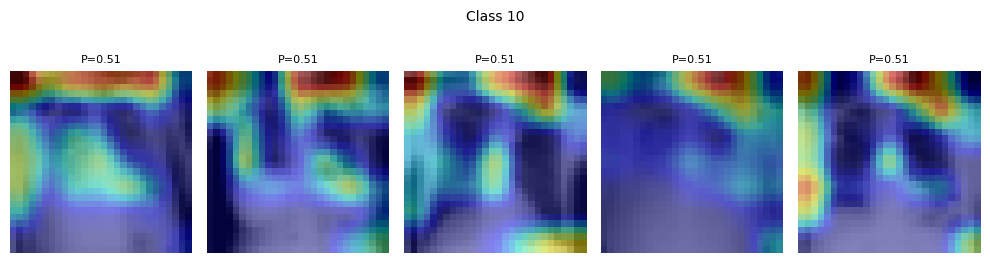


=== Class 11: 5 positive examples ===
idx 3270 | P(class 11) = 0.519
idx 18761 | P(class 11) = 0.518
idx 4542 | P(class 11) = 0.526
idx 56 | P(class 11) = 0.518
idx 18127 | P(class 11) = 0.520


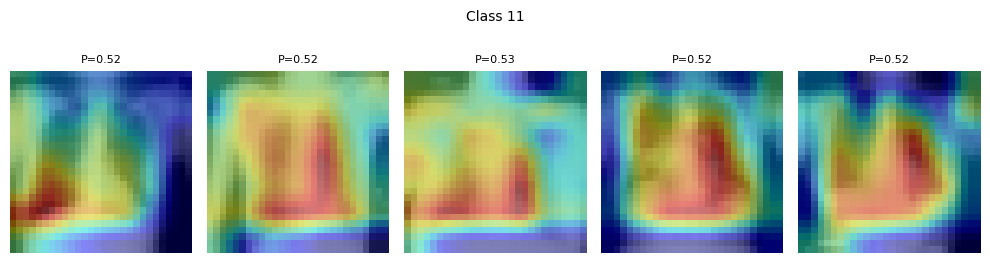


=== Class 12: 5 positive examples ===
idx 17994 | P(class 12) = 0.496
idx 11078 | P(class 12) = 0.495
idx 16297 | P(class 12) = 0.498
idx 12743 | P(class 12) = 0.498
idx 6598 | P(class 12) = 0.498


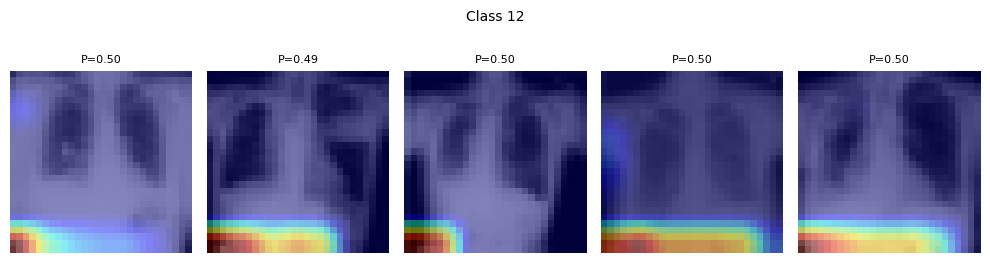


=== Class 13: 5 positive examples ===
idx 1614 | P(class 13) = 0.518
idx 14319 | P(class 13) = 0.523
idx 1604 | P(class 13) = 0.522
idx 3130 | P(class 13) = 0.526
idx 7680 | P(class 13) = 0.522


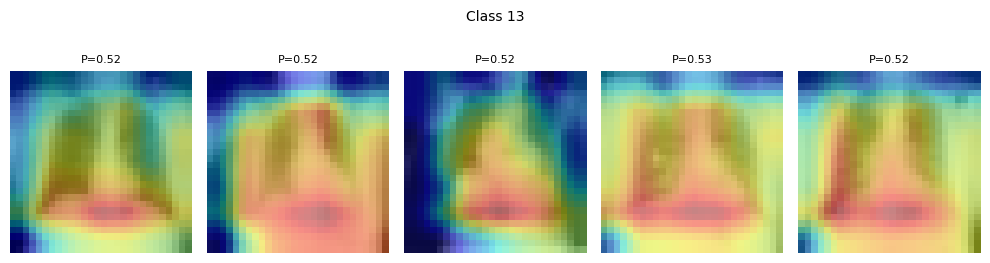

In [ ]:
def overlay_heatmap_gray(images, heatmaps, preds_list, class_index, alpha=0.45, cmap="jet"):

    n = len(images)
    plt.figure(figsize=(n * 2, 2.5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i][..., 0], cmap='gray', vmin=0, vmax=1)
        plt.imshow(heatmaps[i], cmap=cmap, alpha=alpha, vmin=0, vmax=1)
        plt.title(f"P={preds_list[i][class_index]:.2f}", fontsize=8)
        plt.axis('off')
    plt.suptitle(f"Class {class_index}", fontsize=10, y=1.05)
    plt.tight_layout()
    plt.show()



NUM_CLASSES = 14
SAMPLES_PER_CLASS = 5
rng = np.random.default_rng(42)

for c in range(NUM_CLASSES):
    pos_idx = np.where(y_test_chest[:, c] == 1)[0]
    if len(pos_idx) == 0:
        print(f"Class {c}: no positive test examples; skipping.")
        continue

    chosen = rng.choice(pos_idx, size=min(SAMPLES_PER_CLASS, len(pos_idx)), replace=False)
    print(f"\n=== Class {c}: {len(chosen)} positive examples ===")

    imgs, heats, preds_list = [], [], []
    for idx in chosen:
        img = x_test_chest[idx]
        img1 = np.expand_dims(img, 0).astype("float32")
        preds = model.predict(img1, verbose=0)[0]
        heat = gradcam_heatmap_with_submodel(grad_model, img1, class_index=c)
        imgs.append(img)
        heats.append(heat)
        preds_list.append(preds)
        print(f"idx {idx} | P(class {c}) = {preds[c]:.3f}")

    # Show 5 Grad-CAMs in one horizontal row
    overlay_heatmap_gray(imgs, heats, preds_list, class_index=c, alpha=0.45)


## **2d**

In [ ]:
pip install tensorflow-model-optimization


In [ ]:
import tensorflow as tf
import numpy as np
from medmnist import ChestMNIST, INFO
import os

In [ ]:
data_flag = 'chestmnist'
info = INFO[data_flag]

train_dataset = ChestMNIST(split="train", download=True, as_rgb=False)
val_dataset   = ChestMNIST(split="val", download=True, as_rgb=False)
test_dataset  = ChestMNIST(split="test", download=True, as_rgb=False)

# Access numpy arrays and normalize
x_train_2d = np.expand_dims(train_dataset.imgs, -1) / 255.0
x_val_2d   = np.expand_dims(val_dataset.imgs, -1) / 255.0
x_test_2d  = np.expand_dims(test_dataset.imgs, -1) / 255.0

y_train_2d = train_dataset.labels
y_val_2d   = val_dataset.labels
y_test_2d  = test_dataset.labels

print("Train:", x_train_2d.shape, "Test:", x_test_2d.shape)

Train: (78468, 28, 28, 1) Test: (22433, 28, 28, 1)


In [ ]:
model = tf.keras.models.load_model("chestmnist_base_model_flat.keras")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 28 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         3,598 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,175,436 (4.48 MB)

 Trainable params: 391,662 (1.49 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 783,326 (2.99 MB)

In [ ]:
val_probs = model.predict(x_val_2d, verbose=0)
ths = np.full((y_val_2d.shape[1],), 0.5, dtype=np.float32)
grid = np.linspace(0.1, 0.9, 17)
for j in range(y_val_2d.shape[1]):
    best_t, best_acc = 0.5, 0.0
    p = val_probs[:, j]
    y = y_val_2d[:, j]
    for t in grid:
        acc = ((p > t).astype(int) == y).mean()
        if acc > best_acc:
            best_acc, best_t = acc, t
    ths[j] = best_t


**Post-training dynamic range quantization**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_dynamic = converter.convert()


with open("model_dynamic.tflite", "wb") as f:
    f.write(tflite_model_dynamic)

interpreter = tf.lite.Interpreter(model_path="model_dynamic.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
num_test = len(x_test_2d)
num_labels = y_test_2d.shape[1]
dyn_probs = np.zeros((num_test, num_labels), dtype=np.float32)


bs = 128
for start in range(0, num_test, bs):
    end = min(start + bs, num_test)
    batch = x_test_2d[start:end].astype(np.float32)
    for k in range(batch.shape[0]):
        sample = np.expand_dims(batch[k], axis=0)
        interpreter.set_tensor(input_details[0]['index'], sample)
        interpreter.invoke()
        out = interpreter.get_tensor(output_details[0]['index'])
        dyn_probs[start + k] = out[0]

dyn_pred = (dyn_probs >= ths).astype(int)
dynamic_acc = (dyn_pred == y_test_2d).mean()
print(f"Dynamic Range Quantized Accuracy: {dynamic_acc*100:.2f}%")


Saved artifact at '/tmp/tmpj1c2tyzr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  140186246630864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246630672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246632784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246632208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246632592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246635088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246636048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246635856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246635472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246636624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246636432:

**full integer quantization**

In [ ]:
def representative_dataset():
    for i in range(100):
        yield [x_train_2d[i:i+1].astype(np.float32)]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model_int = converter.convert()

with open("model_full_integer.tflite", "wb") as f:
    f.write(tflite_model_int)


interpreter = tf.lite.Interpreter(model_path="model_full_integer.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_scale, input_zero_point = input_details[0]['quantization']

correct = 0
total = 0

for i in range(len(x_test_2d)):

    input_data = x_test_2d[i:i+1] / 255.0

    input_data = input_data / input_scale + input_zero_point
    input_data = np.clip(input_data, -128, 127).astype(np.int8)

    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]['index'])
    pred = (output > 0.5).astype(int)


    correct += np.sum(pred == y_test_2d[i])
    total += y_test_2d.shape[1]

fullint_acc = correct / total
print(f"Full Integer Quantized Accuracy: {fullint_acc*100:.2f}%")


Saved artifact at '/tmp/tmpc1jzlbd2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  140186246630864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246630672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246632784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246632208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246632592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246635088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246636048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246635856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246635472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246636624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140186246636432:

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Full Integer Quantized Accuracy: 94.74%


In [ ]:
import os

def size_kb(path):
    return os.path.getsize(path) / 1024


print("\n Model Size (KB):")
print(f"Original FP32 (.keras): {size_kb('chestmnist_base_model_flat_1.keras'):.1f} KB")
print(f"Dynamic Range (.tflite): {size_kb('model_dynamic.tflite'):.1f} KB")
print(f"Full Integer (.tflite): {size_kb('model_full_integer.tflite'):.1f} KB")


 Model Size (KB):
Original FP32 (.keras): 4669.5 KB
Dynamic Range (.tflite): 392.7 KB
Full Integer (.tflite): 395.4 KB


In [ ]:
print(f"Dynamic Range Quantized Accuracy: {dynamic_acc*100:.2f}%")
print(f"Full Integer Quantized Accuracy: {fullint_acc*100:.2f}%")

Dynamic Range Quantized Accuracy: 94.74%
Full Integer Quantized Accuracy: 94.74%


**QAT in Pytorch**

# **Question 3**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from medmnist import INFO, RetinaMNIST
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score


train_ds_res = RetinaMNIST(split='train', download=True)
val_ds_res   = RetinaMNIST(split='val', download=True)
test_ds_res  = RetinaMNIST(split='test', download=True)

x_train_res, y_train_res = train_ds_res.imgs, train_ds_res.labels
x_val_res, y_val_res = val_ds_res.imgs, val_ds_res.labels
x_test_res, y_test_res = test_ds_res.imgs, test_ds_res.labels


x_train_res = tf.image.rgb_to_grayscale(x_train_res)
x_val_res = tf.image.rgb_to_grayscale(x_val_res)
x_test_res = tf.image.rgb_to_grayscale(x_test_res)


x_train_res = tf.cast(x_train_res, tf.float32) / 255.0
x_val_res   = tf.cast(x_val_res, tf.float32) / 255.0
x_test_res  = tf.cast(x_test_res, tf.float32) / 255.0

print("Training data shape:", x_train_res.shape)


num_classes = len(INFO['retinamnist']['label'])
y_train_res = tf.keras.utils.to_categorical(y_train_res.squeeze(), num_classes)
y_val_res   = tf.keras.utils.to_categorical(y_val_res.squeeze(), num_classes)
y_test_res  = tf.keras.utils.to_categorical(y_test_res.squeeze(), num_classes)


100%|██████████| 3.29M/3.29M [00:04<00:00, 802kB/s]


Training data shape: (1080, 28, 28, 1)


**Building the residual block**

In [ ]:
def residual_block(x, filters):
    shortcut = x


    x = layers.Conv2D(filters, 3, padding='same', strides=1)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)


    x = layers.Conv2D(filters, 3, padding='same', strides=1)(x)
    x = layers.BatchNormalization()(x)


    x = layers.Add()([shortcut, x])
    x = layers.ReLU()(x)
    return x

**Building the model with residual block**

In [ ]:
input_layer = layers.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, 3, padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)


for _ in range(3):
    x = residual_block(x, 32)


x = layers.Conv2D(64, 1, padding='same')(x)
for _ in range(3):
    x = residual_block(x, 64)

x = layers.Conv2D(128, 1, padding='same')(x)
for _ in range(3):
    x = residual_block(x, 128)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
output_layer = layers.Dense(num_classes, activation='softmax')(x)

In [ ]:
model = models.Model(input_layer, output_layer)


optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train_res)


callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_retina_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

history_resNet = model.fit(
    datagen.flow(x_train_res, y_train_res, batch_size=32),
    validation_data=(x_val_res, y_val_res),
    epochs=20,
    callbacks=[callback, checkpoint]
)

Training data shape: (1080, 28, 28, 1)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 28, 28,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 28, 28,    │      9,248 │ re_lu_19[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 28, 28,    │      9,248 │ re_lu_20[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 28, 28,    │          0 │ re_lu_19[0][0],   │
│                     │ 32)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_21 (ReLU)     │ (None, 28, 28,    │          0 │ add_9[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 28, 28,    │      9,248 │ re_lu_21[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_22 (ReLU)     │ (None, 28, 28,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 28, 28,    │      9,248 │ re_lu_22[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 28, 28,    │          0 │ re_lu_21[0][0], 

 Total params: 1,179,461 (4.50 MB)

 Trainable params: 1,176,709 (4.49 MB)

 Non-trainable params: 2,752 (10.75 KB)

Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2127 - loss: 2.5929

34/34 ━━━━━━━━━━━━━━━━━━━━ 170s 4s/step - accuracy: 0.2152 - loss: 2.5774 - val_accuracy: 0.4667 - val_loss: 1.5232
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.4083 - loss: 1.6100 - val_accuracy: 0.2500 - val_loss: 1.5125
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 199s 4s/step - accuracy: 0.4361 - loss: 1.4363 - val_accuracy: 0.2333 - val_loss: 1.5129
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 149s 4s/step - accuracy: 0.4225 - loss: 1.4276 - val_accuracy: 0.1667 - val_loss: 1.5819
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 150s 4s/step - accuracy: 0.4118 - loss: 1.3901 - val_accuracy: 0.1750 - val_loss: 1.5437
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 143s 4s/step - accuracy: 0.4224 - loss: 1.4519 - val_accuracy: 0.1833 - val_loss: 1.5822
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 148s 4s/step - accuracy: 0.4206 - loss: 1.4047 - val_accuracy: 0.2333 - val_loss: 1.5386
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 142s 4s/step - accuracy: 0.4734 - loss: 1.3095 - val_accuracy: 0.2250 - val_loss: 1.

**Plotting learning curves**

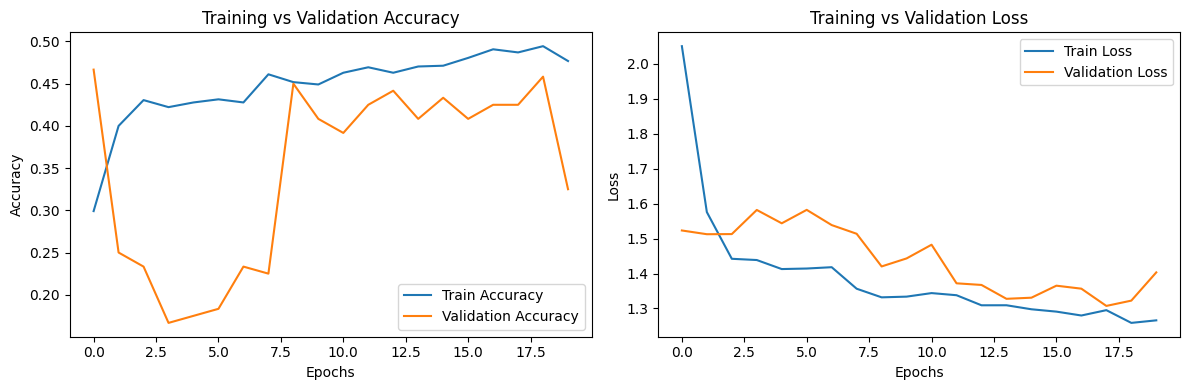

Test Accuracy: 0.458, Test Loss: 1.330
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step
Test AUC (macro-average): 0.672


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_resNet.history['accuracy'], label='Train Accuracy')
axes[0].plot(history_resNet.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Training vs Validation Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history_resNet.history['loss'], label='Train Loss')
axes[1].plot(history_resNet.history['val_loss'], label='Validation Loss')
axes[1].set_title('Training vs Validation Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


test_loss, test_acc = model.evaluate(x_test_res, y_test_res, verbose=0)
print(f"Test Accuracy: {test_acc:.3f}, Test Loss: {test_loss:.3f}")


y_pred_probs = model.predict(x_test_res)
auc = roc_auc_score(y_test_res, y_pred_probs, multi_class='ovr', average='macro')
print(f"Test AUC (macro-average): {auc:.3f}")